In [207]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [208]:
from gensim import corpora, models, matutils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [209]:
df = pd.read_pickle('reviews.pickle')

In [210]:
df.shape

(98613, 11)

In [211]:
df.columns

Index([    u'review_id',          u'name',         u'title',       u'content',
             u'recency',       u'staysum',         u'stars',  u'reviewer_loc',
         u'mon_of_stay', u'yrmon_of_stay',   u'travel_type'],
      dtype='object')

In [212]:
df.drop(['review_id','staysum','reviewer_loc'],axis=1,inplace=True)

In [213]:
df.columns

Index([         u'name',         u'title',       u'content',       u'recency',
               u'stars',   u'mon_of_stay', u'yrmon_of_stay',   u'travel_type'],
      dtype='object')

In [214]:
df.recency.unique()

array(['2017-04-07T00:00:00.000000000', '2017-04-06T00:00:00.000000000',
       '2017-04-05T00:00:00.000000000', ...,
       '2010-01-28T00:00:00.000000000', '2010-01-27T00:00:00.000000000',
       '2010-01-13T00:00:00.000000000'], dtype='datetime64[ns]')

In [215]:
df.isnull().sum()

name             0
title            0
content          0
recency          0
stars            0
mon_of_stay      0
yrmon_of_stay    0
travel_type      0
dtype: int64

In [216]:
#create hotel-level reviews dataframe, combining all of hotel's reviews into one
df_by_hotel = df.groupby('name').agg({'content': lambda x: ' '.join(x)}).reset_index()

In [217]:
df_by_hotel.head()

,name,content
0,1 Hotel Central Park,we have had numerous stays at hotel one in ny...
1,11 Howard,i stayed 5nights in this hotel and highly rec...
2,3 West Club,great location but the room was terribly outd...
3,36 Hudson Hotel,stayed at the hotel over the new year staff w...
4,414 Hotel,we stayed at the 414 for the second time and ...


In [218]:
df_by_hotel.shape

(444, 2)

In [219]:
df_by_hotel.content[0]

u' we have had numerous stays at hotel one in nyc the hotel is greatextremely comfortable clean and with a fantastic staff i am finally getting around to write this after four stays at the hotelall were wonderful also staff goes above and beyondin particular antigona  janessa great place to stayelizabeth   1 hotel is a beautiful breath of fresh air close to central park its the perfect location for the park the theater district shopping and museums the staff was very friendly and helpful and went out of their way for us many times we had a lovely window seat to watch the world go by on a rainy afternoon we cant wait to come back   this hotel is amazing  so different from any other hotel we have stayed in from the minute you walk in you feel at home it doesnt feel like a cold soulless hotel but like a warm and inviting living room the staff at the front desk are friendly and polite and quick  checking in was a breeze we had booked a city room which was more than adequate for what we nee

In [220]:
from unicodedata import normalize

In [221]:
#remove Unicode characters and save content to new column
df_by_hotel['content_utf8'] = df_by_hotel.content.str.normalize('NFKD').str.encode('ascii','ignore')

In [222]:
df_by_hotel.content_utf8[0]

' we have had numerous stays at hotel one in nyc the hotel is greatextremely comfortable clean and with a fantastic staff i am finally getting around to write this after four stays at the hotelall were wonderful also staff goes above and beyondin particular antigona  janessa great place to stayelizabeth   1 hotel is a beautiful breath of fresh air close to central park its the perfect location for the park the theater district shopping and museums the staff was very friendly and helpful and went out of their way for us many times we had a lovely window seat to watch the world go by on a rainy afternoon we cant wait to come back   this hotel is amazing  so different from any other hotel we have stayed in from the minute you walk in you feel at home it doesnt feel like a cold soulless hotel but like a warm and inviting living room the staff at the front desk are friendly and polite and quick  checking in was a breeze we had booked a city room which was more than adequate for what we need

In [223]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = list(ENGLISH_STOP_WORDS)
print stop_words

['all', 'six', 'less', 'being', 'indeed', 'over', 'move', 'anyway', 'fifty', 'four', 'not', 'own', 'through', 'yourselves', 'go', 'where', 'mill', 'only', 'find', 'before', 'one', 'whose', 'system', 'how', 'somewhere', 'with', 'thick', 'show', 'had', 'enough', 'should', 'to', 'must', 'whom', 'seeming', 'under', 'ours', 'has', 'might', 'thereafter', 'latterly', 'do', 'them', 'his', 'around', 'than', 'get', 'very', 'de', 'none', 'cannot', 'every', 'whether', 'they', 'front', 'during', 'thus', 'now', 'him', 'nor', 'name', 'several', 'hereafter', 'always', 'who', 'cry', 'whither', 'this', 'someone', 'either', 'each', 'become', 'thereupon', 'sometime', 'side', 'two', 'therein', 'twelve', 'because', 'often', 'ten', 'our', 'eg', 'some', 'back', 'up', 'namely', 'towards', 'are', 'further', 'beyond', 'ourselves', 'yet', 'out', 'even', 'will', 'what', 'still', 'for', 'bottom', 'mine', 'since', 'please', 'forty', 'per', 'its', 'everything', 'behind', 'un', 'above', 'between', 'it', 'neither', 'se

In [224]:
stop_words2_str = 'i, me, my, myself, we, our, ours, ourselves, you, your, yours, yourself, yourselves, he, him, his, himself, she, her, hers, herself, it, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, should, now'

In [225]:
stop_words2 = stop_words2_str.split(', ')
stop_words2

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

In [226]:
stop_words_final = []
for word in stop_words2:
    if word in stop_words:
        pass
    else:
        stop_words.append(word)

In [135]:
# vectorizer = CountVectorizer(stop_words=stop_words)
# X = vectorizer.fit_transform(df_by_hotel['content'])

In [136]:
# X.shape

In [137]:
# type(X)

In [227]:
X_text_col = df_by_hotel['content_utf8']

In [228]:
# Preprocess text data to Tfidf
vect = TfidfVectorizer(stop_words=stop_words,ngram_range=(1,2),min_df=0.1,max_df=0.8)
X_text = vect.fit_transform(X_text_col)

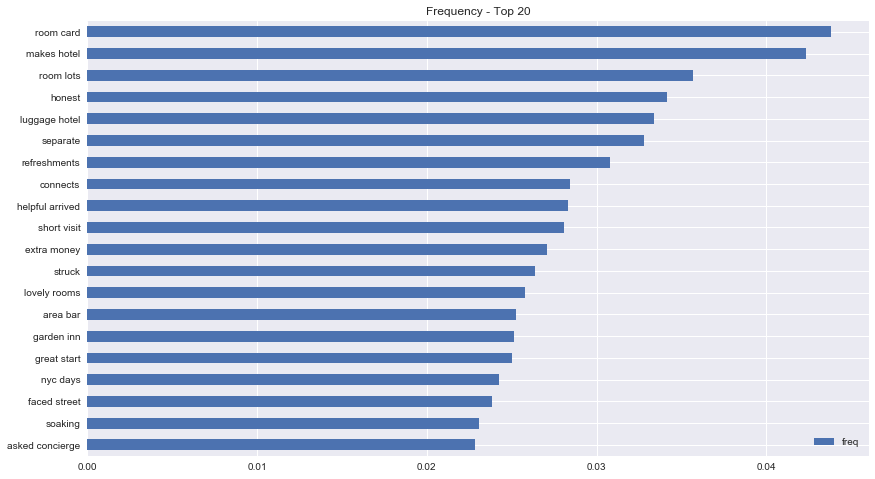

In [229]:
X_text_df = pd.DataFrame(X_text.toarray(), columns=vect.vocabulary_)
tf_df = pd.DataFrame(X_text_df.mean(), columns=["freq"])
title = "Frequency - Top 20"
tf_df.sort_values("freq").tail(20).plot(kind="barh", title=title, figsize=(14,8))
plt.show()

In [230]:
X_text_df.head()

,fix,square hells,staff quite,honeymoon,ground,quieter room,avenue times,location away,quite lot,sorted,...,nyc staff,street blocks,city view,250 night,710,unhappy,times stayed,especially concierge,year ago,restaurants walking
0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.016459
1,0.006366,0.0,0.0,0.0,0.000000,0.000000,0.005940,0.005146,0.0,0.006366,...,0.000000,0.0,0.017526,0.006407,0.000000,0.0,0.004131,0.006439,0.0,0.000000
2,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.016631,0.0,0.018660,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.000000,0.007167,0.022444,0.034026,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.007805,0.012165,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.003788,0.003744,0.011725,0.005079,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.005422,0.0,0.008154,0.000000,0.0,0.000000


In [231]:
X_text_df.shape

(444, 13522)

In [232]:
tf_df.shape

(13522, 1)

In [233]:
tf_df.tail()

,freq
unhappy,0.001329
times stayed,0.002611
especially concierge,0.005441
year ago,0.001800
restaurants walking,0.001396


In [234]:
vect.vocabulary_

{u'fix': 4236,
 u'square hells': 11114,
 u'staff quite': 11270,
 u'honeymoon': 5403,
 u'ground': 5038,
 u'quieter room': 9033,
 u'avenue times': 863,
 u'location away': 6725,
 u'quite lot': 9053,
 u'sorted': 10934,
 u'quibble': 8986,
 u'inconsistent': 6075,
 u'welcomed': 13163,
 u'breakfast time': 1626,
 u'welcomes': 13164,
 u'staff food': 11209,
 u'hotel going': 5608,
 u'coffeemaker': 2399,
 u'girls trip': 4633,
 u'overall highly': 8219,
 u'shocking': 10510,
 u'swipe': 11957,
 u'fabulous view': 4001,
 u'quiet rooms': 9026,
 u'great selection': 4972,
 u'room long': 9854,
 u'family friendly': 4044,
 u'room relatively': 9930,
 u'staring': 11352,
 u'different hotel': 3218,
 u'room higher': 9816,
 u'service hotel': 10411,
 u'flawless': 4254,
 u'extremely slow': 3984,
 u'tv nice': 12550,
 u'runs': 10178,
 u'tiny rooms': 12292,
 u'worth stay': 13381,
 u'right subway': 9606,
 u'relatively new': 9339,
 u'broadway plays': 1660,
 u'bed linens': 1172,
 u'doormen desk': 3406,
 u'ride away': 9574,


In [235]:
feature_names = vect.get_feature_names()

In [236]:
len(feature_names)

13522

In [237]:
X_text

<444x13522 sparse matrix of type '<type 'numpy.float64'>'
	with 1488239 stored elements in Compressed Sparse Row format>

In [238]:
type(feature_names)

list

In [239]:
feature_names

[u'10 15',
 u'10 blocks',
 u'10 day',
 u'10 days',
 u'10 min',
 u'10 mins',
 u'10 minute',
 u'10 minutes',
 u'10 nights',
 u'10 pm',
 u'10 year',
 u'10 years',
 u'100 night',
 u'100 recommend',
 u'1000',
 u'1010',
 u'1015',
 u'1015 min',
 u'1015 minute',
 u'1015 minutes',
 u'1030',
 u'10am',
 u'10min',
 u'10pm',
 u'10th',
 u'10th floor',
 u'11',
 u'11 pm',
 u'110',
 u'1100',
 u'1130',
 u'11am',
 u'11pm',
 u'11th',
 u'11th floor',
 u'12 block',
 u'12 blocks',
 u'12 hours',
 u'120',
 u'1200',
 u'1230',
 u'125',
 u'12pm',
 u'12th',
 u'12th floor',
 u'13',
 u'130',
 u'13th',
 u'14',
 u'14th',
 u'14th floor',
 u'15 min',
 u'15 mins',
 u'15 minute',
 u'15 minutes',
 u'15 years',
 u'150',
 u'150 night',
 u'1500',
 u'1520',
 u'1520 minutes',
 u'15th',
 u'15th floor',
 u'16',
 u'160',
 u'16th',
 u'16th floor',
 u'17',
 u'17th',
 u'17th floor',
 u'18',
 u'180',
 u'18th',
 u'18th floor',
 u'19',
 u'19th',
 u'19th floor',
 u'1am',
 u'1pm',
 u'1st',
 u'1st floor',
 u'1st time',
 u'20 min',
 u'20 mi

#### PREPARE DATASETS FOR MODELING

In [323]:
df_hotel = pd.read_pickle('df_446.pickle')

In [324]:
df_hotel.shape

(446, 98)

In [325]:
df_hotel.columns

Index([               u'name',             u'st_addr',                u'city',
                     u'state',              u'zip_cd',        u'excellent_ct',
               u'verygood_ct',          u'average_ct',             u'poor_ct',
               u'terrible_ct',            u'families',             u'couples',
                      u'solo',            u'business',             u'friends',
                    u'spring',              u'summer',                u'fall',
                    u'winter',         u'description',           u'full_addr',
                     u'top30', u'pct_english_reviews',           u'rating_ct',
             u'excellent_pct',        u'verygood_pct',         u'average_pct',
                  u'poor_pct',        u'terrible_pct',           u'travel_ct',
              u'families_pct',         u'couples_pct',            u'solo_pct',
              u'business_pct',         u'friends_pct',           u'season_ct',
                u'spring_pct',          u'summer_pct

In [243]:
df_by_hotel.columns

Index([u'name', u'content', u'content_utf8'], dtype='object')

In [244]:
df_by_hotel.name.unique().size

444

In [245]:
#replace inconsistent hotel names in the reviews dataset to allow for merge with hotel-level data
df_by_hotel.loc[df_by_hotel['name'] == 'A Hospitality Company, Inc.','name'] = 'A Hospitality Company Inc.'
df_by_hotel.loc[df_by_hotel['name'] == 'Arlo SoHo','name'] = 'Arlo Hudson Square'
df_by_hotel.loc[df_by_hotel['name'] == 'Carlton Hotel, Autograph Collection','name'] = 'Carlton Hotel Autograph Collection'
df_by_hotel.loc[df_by_hotel['name'] == 'Club Quarters Hotel, Grand Central','name'] = 'Club Quarters Hotel Grand Central'
df_by_hotel.loc[df_by_hotel['name'] == 'Club Quarters Hotel, Midtown','name'] = 'Club Quarters Hotel Midtown'
df_by_hotel.loc[df_by_hotel['name'] == 'Club Quarters Hotel, Wall Street','name'] = 'Club Quarters Hotel Wall Street'
df_by_hotel.loc[df_by_hotel['name'] == 'Club Quarters Hotel, World Trade Center','name'] = 'Club Quarters Hotel World Trade Center'
df_by_hotel.loc[df_by_hotel['name'] == 'Club Quarters Hotel, opposite Rockefeller Center','name'] = 'Club Quarters Hotel opposite Rockefeller Center'
df_by_hotel.loc[df_by_hotel['name'] == 'Comfort Inn Sunset Park / Park Slope','name'] = 'Comfort Inn Sunset Park / Park Slope'
df_by_hotel.loc[df_by_hotel['name'] == 'Distrikt Hotel Times Square','name'] = 'Distrikt Hotel'
df_by_hotel.loc[df_by_hotel['name'].str.contains('Dumont'),'name'] = 'Dumont NYC-an Affinia hotel'
df_by_hotel.loc[df_by_hotel['name'].str.contains('Fifty NYC'),'name'] = 'Fifty NYC-an Affinia hotel'
#df_by_hotel.loc[df_by_hotel['name'] == 'Flushing Motel','name'] = ''
df_by_hotel.loc[df_by_hotel['name'].str.contains('Gardens'),'name'] = 'Gardens NYC-an Affinia hotel'
df_by_hotel.loc[df_by_hotel['name'] == 'Gild Hall, a Thompson Hotel','name'] = 'Gild Hall a Thompson Hotel'
df_by_hotel.loc[df_by_hotel['name'] == 'Homewood Suites by Hilton New York/Midtown Manhattan Times Square-South, NY','name'] = 'Homewood Suites by Hilton New York/Midtown Manhattan Times Square-South NY'
#df_by_hotel.loc[df_by_hotel['name'] == 'Hudson River Hotel','name'] = ''
df_by_hotel.loc[df_by_hotel['name'] == 'Innside New York NoMad','name'] = 'Innside New York Nomad'
#df_by_hotel.loc[df_by_hotel['name'] == 'LUMA Hotel Times Square','name'] = ''
df_by_hotel.loc[df_by_hotel['name'] == 'Langham Place, New York, Fifth Avenue','name'] = 'Langham Place New York Fifth Avenue'
df_by_hotel.loc[df_by_hotel['name'] == 'Mandarin Oriental, New York','name'] = 'Mandarin Oriental New York'
df_by_hotel.loc[df_by_hotel['name'] == 'Marriott Vacation Club Pulse, New York City','name'] = 'Marriott Vacation Club Pulse New York City'
df_by_hotel.loc[df_by_hotel['name'].str.contains('Shelburne'),'name'] = 'Shelburne NYC-an Affinia hotel'
df_by_hotel.loc[df_by_hotel['name'] == 'Smyth, a Thompson Hotel','name'] = 'Smyth a Thompson Hotel'
df_by_hotel.loc[df_by_hotel['name'] == 'The Algonquin Hotel Times Square, Autograph Collection','name'] = 'The Algonquin Hotel Times Square Autograph Collection'
df_by_hotel.loc[df_by_hotel['name'] == 'The Beekman, A Thompson Hotel','name'] = 'The Beekman A Thompson Hotel'
df_by_hotel.loc[df_by_hotel['name'] == 'The Carlyle, A Rosewood Hotel','name'] = 'The Carlyle A Rosewood Hotel'
df_by_hotel.loc[df_by_hotel['name'] == 'The Chatwal, A Luxury Collection Hotel, New York','name'] = 'The Chatwal A Luxury Collection Hotel New York'
df_by_hotel.loc[df_by_hotel['name'].str.contains('St Giles Hotel'),'name'] = 'The Court - A St Giles Hotel'
df_by_hotel.loc[df_by_hotel['name'] == 'The Lexington New York City, Autograph Collection','name'] = 'The Lexington New York City Autograph Collection'
df_by_hotel.loc[df_by_hotel['name'] == 'The Pierre, A Taj Hotel, New York','name'] = 'The Pierre A Taj Hotel New York'
df_by_hotel.loc[df_by_hotel['name'] == 'The Renwick Hotel New York City, Curio Collection by Hilton','name'] = 'The Renwick Hotel New York City Curio Collection by Hilton'
df_by_hotel.loc[df_by_hotel['name'] == 'The Ritz-Carlton New York, Battery Park','name'] = 'The Ritz-Carlton New York Battery Park'
df_by_hotel.loc[df_by_hotel['name'] == 'The Ritz-Carlton New York, Central Park','name'] = 'The Ritz-Carlton New York Central Park'
df_by_hotel.loc[df_by_hotel['name'] == 'The Standard, East Village','name'] = 'The Standard East Village'
df_by_hotel.loc[df_by_hotel['name'] == 'The Standard, High Line','name'] = 'The Standard High Line'
df_by_hotel.loc[df_by_hotel['name'] == 'nyma, the New York Manhattan Hotel','name'] = 'nyma the New York Manhattan Hotel'

In [246]:
df_by_hotel.drop('content',axis=1,inplace=True)

In [247]:
df_by_hotel.rename(columns={'name':'hotel_name'},inplace=True)

In [248]:
df_by_hotel.shape

(444, 2)

In [249]:
df_combd = pd.concat([df_by_hotel,X_text_df],axis=1)

In [250]:
df_combd.shape

(444, 13524)

In [326]:
df_hotel.rename(columns={'name':'hotel_name'},inplace=True)

In [327]:
df_hotel.shape

(446, 98)

In [328]:
df_hotel.columns

Index([         u'hotel_name',             u'st_addr',                u'city',
                     u'state',              u'zip_cd',        u'excellent_ct',
               u'verygood_ct',          u'average_ct',             u'poor_ct',
               u'terrible_ct',            u'families',             u'couples',
                      u'solo',            u'business',             u'friends',
                    u'spring',              u'summer',                u'fall',
                    u'winter',         u'description',           u'full_addr',
                     u'top30', u'pct_english_reviews',           u'rating_ct',
             u'excellent_pct',        u'verygood_pct',         u'average_pct',
                  u'poor_pct',        u'terrible_pct',           u'travel_ct',
              u'families_pct',         u'couples_pct',            u'solo_pct',
              u'business_pct',         u'friends_pct',           u'season_ct',
                u'spring_pct',          u'summer_pct

In [329]:
df_hotel.columns.tolist()[1:5]

[u'st_addr', u'city', u'state', u'zip_cd']

In [330]:
drop_list = df_hotel.columns.tolist()[1:5] + df_hotel.columns.tolist()[19:21]
drop_list

[u'st_addr', u'city', u'state', u'zip_cd', u'description', 'full_addr']

In [331]:
df_hotel_small = df_hotel.drop(drop_list,axis=1)

In [332]:
df_hotel_small.shape

(446, 92)

In [333]:
df_combd_all = df_combd.merge(df_hotel_small,how='inner',on='hotel_name')

In [334]:
df_combd_all.shape

(440, 13615)

In [335]:
#hotels in the hotel-level dataset that were not found in the review dataset
df_hotel[(~df_hotel.hotel_name.isin(df_combd_all.hotel_name))]

,hotel_name,st_addr,city,state,zip_cd,excellent_ct,verygood_ct,average_ct,poor_ct,terrible_ct,...,zip_5_10027,zip_5_10028,zip_5_10032,zip_5_10033,zip_5_10036,zip_5_10038,zip_5_10065,zip_5_10078,zip_5_10128,zip_5_10282
1,The Towers of the Waldorf Astoria - TEMPORARIL...,100 E 50th St,New York City,NY,10022-6844,1381.0,245.0,107.0,69.0,28.0,...,0,0,0,0,0,0,0,0,0,0
85,Oxbridge Apts Gramecy Park,266 3rd Ave,New York City,NY,10010-7445,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
92,East Bridge,367 33rd St,New York City,NY,10003,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
102,Hotel Delmonico,502 Park Ave,New York City,NY,10022-1108,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
109,The Helmsley Windsor,100 West 58th Street,New York City,NY,10019,7.0,6.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
236,Fairfield Inn & Suites New York Manhattan/Time...,330 West 40th Street,New York City,NY,10018,446.0,482.0,159.0,40.0,30.0,...,0,0,0,0,0,0,0,0,0,0


In [336]:
#hotels in the reviews dataset that were not found in the hotel-level dataset (2 of these were removed in Capstone based on zip code)
df_by_hotel[~df_by_hotel.hotel_name.isin(df_combd_all.hotel_name)]

,hotel_name,content_utf8
60,Comfort Inn Sunset Park / Park Slope,comfortable hotel for a short stay friendly s...
114,Flushing Motel,booked 2 nights 1st tried to sleep on a thin ...
202,Hudson River Hotel,it is a great budget hotel with great accessi...
218,LUMA Hotel Times Square,we really enjoyed our stay at this hotel and ...


In [337]:
#ranks of hotels that were omitted from merge because they had no reviews
df_hotel[(~df_hotel.hotel_name.isin(df_combd_all.hotel_name))]['rank_num']

1       26.0
85     419.0
92     411.0
102    400.0
109    393.0
236    241.0
Name: rank_num, dtype: float64

In [338]:
#Ranks missing: 419, 411, 400, 393, 241, 26 (shift values so there are no gaps)
def shift_values(orig_val):
    if orig_val <= 26:
        new_val = orig_val
    elif (orig_val > 26) & (orig_val <= 240):
        new_val = orig_val - 1
    elif (orig_val > 241) & (orig_val <= 392):
        new_val = orig_val - 2
    elif (orig_val > 393) & (orig_val <= 399):
        new_val = orig_val - 3
    elif (orig_val > 400) & (orig_val <= 410):
        new_val = orig_val - 4
    elif (orig_val > 411) & (orig_val <= 418):
        new_val = orig_val - 5
    elif orig_val > 419:
        new_val = orig_val - 6
    return new_val

In [339]:
df_combd_all['rank_num'] = df_combd_all.rank_num.apply(lambda x: shift_values(x))

In [340]:
len(df_combd_all.rank_num.unique())

440

In [341]:
df_combd_all.rank_num.describe()

count    440.000000
mean     220.500000
std      127.161315
min        1.000000
25%      110.750000
50%      220.500000
75%      330.250000
max      440.000000
Name: rank_num, dtype: float64

In [342]:
#reconstruct top30 column to account for adjusted ranks
df_combd_all['top30'] = df_combd_all.rank_num.apply(lambda x: 1 if x <= 30 else 0)

In [343]:
df_combd_all.top30.value_counts()

0    410
1     30
Name: top30, dtype: int64

In [344]:
class_cols = [col for col in list(df_hotel) if col.startswith('hclass_num_')]
class_cols

['hclass_num_1.0',
 'hclass_num_1.5',
 'hclass_num_2.0',
 'hclass_num_2.5',
 'hclass_num_3.0',
 'hclass_num_3.5',
 'hclass_num_4.0',
 'hclass_num_4.5',
 'hclass_num_5.0']

In [345]:
zip_cols = [col for col in list(df_hotel) if col.startswith('zip_5')]
zip_cols

[u'zip_5_10001',
 u'zip_5_10002',
 u'zip_5_10003',
 u'zip_5_10004',
 u'zip_5_10005',
 u'zip_5_10006',
 u'zip_5_10007',
 u'zip_5_10010',
 u'zip_5_10011',
 u'zip_5_10012',
 u'zip_5_10013',
 u'zip_5_10014',
 u'zip_5_10016',
 u'zip_5_10017',
 u'zip_5_10018',
 u'zip_5_10019',
 u'zip_5_10021',
 u'zip_5_10022',
 u'zip_5_10023',
 u'zip_5_10024',
 u'zip_5_10025',
 u'zip_5_10027',
 u'zip_5_10028',
 u'zip_5_10032',
 u'zip_5_10033',
 u'zip_5_10036',
 u'zip_5_10038',
 u'zip_5_10065',
 u'zip_5_10078',
 u'zip_5_10128',
 u'zip_5_10282']

In [346]:
hotel_cols = ['hotel_name','top30','rank_num','rooms_num','prange_low','prange_high',
         'amen_wifi','amen_room_service','amen_restaurant','amen_bar_lounge','amen_gym',
         'amen_spa','amen_breakfast','amen_pool','amen_internet','amen_parking'] + zip_cols + class_cols

In [347]:
#create dataframe with target variables and hotel-level predictors
XY_df = df_combd_all[hotel_cols]

In [348]:
XY_df.shape

(440, 56)

In [349]:
XY_df.columns

Index([       u'hotel_name',             u'top30',          u'rank_num',
               u'rooms_num',        u'prange_low',       u'prange_high',
               u'amen_wifi', u'amen_room_service',   u'amen_restaurant',
         u'amen_bar_lounge',          u'amen_gym',          u'amen_spa',
          u'amen_breakfast',         u'amen_pool',     u'amen_internet',
            u'amen_parking',       u'zip_5_10001',       u'zip_5_10002',
             u'zip_5_10003',       u'zip_5_10004',       u'zip_5_10005',
             u'zip_5_10006',       u'zip_5_10007',       u'zip_5_10010',
             u'zip_5_10011',       u'zip_5_10012',       u'zip_5_10013',
             u'zip_5_10014',       u'zip_5_10016',       u'zip_5_10017',
             u'zip_5_10018',       u'zip_5_10019',       u'zip_5_10021',
             u'zip_5_10022',       u'zip_5_10023',       u'zip_5_10024',
             u'zip_5_10025',       u'zip_5_10027',       u'zip_5_10028',
             u'zip_5_10032',       u'zip_5_10033', 

In [350]:
#leave just the full set of predictors in the full combined dataframe
df_combd_all.drop(['hotel_name','top30','rank_num'],axis=1,inplace=True)

In [351]:
df_combd_all.shape

(440, 13612)

In [352]:
#Identify target column
y = XY_df.top30

In [353]:
y.shape

(440,)

In [354]:
y.value_counts()

0    410
1     30
Name: top30, dtype: int64

In [355]:
#identify hotel-level predictors
X = XY_df.drop(['hotel_name','top30','rank_num'],axis=1)

In [356]:
X.shape

(440, 53)

In [357]:
#Identify columns that needs to be scaled
X_cols_for_scaling = ['rooms_num','prange_low','prange_high']

In [358]:
X_for_scaling = X[X_cols_for_scaling]

In [359]:
X_for_scaling.shape

(440, 3)

In [360]:
from sklearn.preprocessing import MinMaxScaler

In [361]:
mm = MinMaxScaler()
Xn = mm.fit_transform(X_for_scaling)

In [362]:
Xn_df = pd.DataFrame(Xn, columns=X_cols_for_scaling)

In [363]:
Xn_df.head()

,rooms_num,prange_low,prange_high
0,0.115207,0.400740,0.210181
1,0.111111,0.300863,0.565517
2,0.011777,0.167694,0.074548
3,0.017409,0.152898,0.076847
4,0.009217,0.316893,0.108046


In [364]:
#Identify remaining predictor columns (all binary)
X_cols_remaining = ['amen_wifi','amen_room_service','amen_restaurant','amen_bar_lounge','amen_gym',
         'amen_spa','amen_breakfast','amen_pool','amen_internet','amen_parking'] + zip_cols + class_cols

In [365]:
X_remaining = X[X_cols_remaining]

In [366]:
X_remaining.shape

(440, 50)

In [367]:
Xn_df = pd.concat([Xn_df,X_remaining],axis=1)

In [368]:
Xn_df.shape

(440, 53)

In [369]:
Xn_df.columns

Index([        u'rooms_num',        u'prange_low',       u'prange_high',
               u'amen_wifi', u'amen_room_service',   u'amen_restaurant',
         u'amen_bar_lounge',          u'amen_gym',          u'amen_spa',
          u'amen_breakfast',         u'amen_pool',     u'amen_internet',
            u'amen_parking',       u'zip_5_10001',       u'zip_5_10002',
             u'zip_5_10003',       u'zip_5_10004',       u'zip_5_10005',
             u'zip_5_10006',       u'zip_5_10007',       u'zip_5_10010',
             u'zip_5_10011',       u'zip_5_10012',       u'zip_5_10013',
             u'zip_5_10014',       u'zip_5_10016',       u'zip_5_10017',
             u'zip_5_10018',       u'zip_5_10019',       u'zip_5_10021',
             u'zip_5_10022',       u'zip_5_10023',       u'zip_5_10024',
             u'zip_5_10025',       u'zip_5_10027',       u'zip_5_10028',
             u'zip_5_10032',       u'zip_5_10033',       u'zip_5_10036',
             u'zip_5_10038',       u'zip_5_10065', 

In [370]:
XY_df.to_pickle('XY_df.pickle')

In [371]:
Xn_df.to_pickle('Xn_df.pickle')

In [372]:
df_combd_all.to_pickle('df_combd_all.pickle')

In [373]:
XY_df.columns

Index([       u'hotel_name',             u'top30',          u'rank_num',
               u'rooms_num',        u'prange_low',       u'prange_high',
               u'amen_wifi', u'amen_room_service',   u'amen_restaurant',
         u'amen_bar_lounge',          u'amen_gym',          u'amen_spa',
          u'amen_breakfast',         u'amen_pool',     u'amen_internet',
            u'amen_parking',       u'zip_5_10001',       u'zip_5_10002',
             u'zip_5_10003',       u'zip_5_10004',       u'zip_5_10005',
             u'zip_5_10006',       u'zip_5_10007',       u'zip_5_10010',
             u'zip_5_10011',       u'zip_5_10012',       u'zip_5_10013',
             u'zip_5_10014',       u'zip_5_10016',       u'zip_5_10017',
             u'zip_5_10018',       u'zip_5_10019',       u'zip_5_10021',
             u'zip_5_10022',       u'zip_5_10023',       u'zip_5_10024',
             u'zip_5_10025',       u'zip_5_10027',       u'zip_5_10028',
             u'zip_5_10032',       u'zip_5_10033', 

In [374]:
print df_combd_all.shape, XY_df.shape, Xn_df.shape

(440, 13612) (440, 56) (440, 53)
